<a href="https://colab.research.google.com/github/sean-halpin/diffusion_models/blob/main/min_diffusion_dct_celeb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/images/*

In [ ]:
!mkdir -p /content/images/

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

## CIFAR

### UNet

In [ ]:
"""
Simple Unet Structure.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv3(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )

        self.is_res = is_res

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.main(x)
        if self.is_res:
            x = x + self.conv(x)
            return x / 1.414
        else:
            return self.conv(x)


class UnetDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetDown, self).__init__()
        layers =  [
                    Conv3(in_channels, out_channels), nn.MaxPool2d(2)
                  ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            Conv3(out_channels, out_channels),
            Conv3(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, skip), 1)
        x = self.model(x)

        return x


class TimeSiren(nn.Module):
    def __init__(self, emb_dim: int) -> None:
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x


class NaiveUnet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_feat: int = 256) -> None:
        super(NaiveUnet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.n_feat = n_feat

        self.init_conv = nn.Sequential(
            Conv3(in_channels, n_feat, is_res=True)
        )
        # self.init_conv = Conv3(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.ReLU())

        self.timeembed = TimeSiren(2 * n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Conv2d(2 * n_feat, self.out_channels, 3, 1, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        thro = self.to_vec(down3)
        temb = self.timeembed(t).view(-1, self.n_feat * 2, 1, 1)

        thro = self.up0(thro + temb)

        up1 = self.up1(thro, down3) + temb
        up2 = self.up2(up1, down2)
        up3 = self.up3(up2, down1)

        out = self.out(torch.cat((up3, x), 1))

        return out

### Denoising Diffusion Probabilistic Model

In [ ]:
from typing import Dict, Tuple


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Dict, Optional, Tuple


class DDPM(nn.Module):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper.
        """

        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(x.device)
        # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * eps
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        return self.criterion(eps, self.eps_model(x_t, _ts / self.n_T))

    def sample(self, n_sample: int, size, device, imgg: Optional[any] = None) -> torch.Tensor:

        # x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)
        x_i = torch.randn(n_sample, *size).to(device)


        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(
                x_i, torch.tensor(i / self.n_T).to(device).repeat(n_sample, 1)
            )
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

### Train DDPM on CIFAR

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.datasets import CelebA
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from pathlib import Path


def create_model(load_pth = False, device: str = "cuda:0"):
    ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
    if load_pth:
      my_file = Path("ddpm.pth")
      if my_file.is_file(): 
        print("Loading Model from File")
        ddpm.load_state_dict(torch.load("ddpm.pth"))
    ddpm.to(device)
    return ddpm

def train(ddpm: Optional[any] = None, n_epoch: int = 1, device: str = "cuda:0", 
          dataset = None, x_size=32, y_size=32, modulo_print=1) -> None:

    if ddpm == None:
      print("Creating Model")
      ddpm = create_model()

    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)
    optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
          if i % modulo_print == 0:
            xh = ddpm.sample(8, (3, x_size, y_size), device)
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
            plt.imshow(
                transforms.functional.vflip(
                  transforms.functional.rotate(grid.cpu(), 90).T)
                )
            plt.show()
            save_image(grid, f"/content/images/ddpm_sample_{i}.png")
            # save model
            torch.save(ddpm.state_dict(), f"./ddpm.pth")

### Begin Training

In [ ]:
ddpm = create_model(load_pth=True)

In [ ]:
x_size = 32
y_size = 32

In [ ]:
tf = transforms.Compose(
  [
    transforms.Resize((x_size, y_size)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

In [ ]:
dataset = CelebA(
    "./data",
    # train=True,
    download=True,
    transform=tf,
)

# dataset = CIFAR10(
#     "./data",
#     train=True,
#     download=True,
#     transform=tf,
# )

Files already downloaded and verified


In [ ]:
subset = torch.utils.data.Subset(dataset, range(0,18000))

In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
# torch.cuda.memory_summary(device=None, abbreviated=False)

Epoch 0 : 


loss: 0.4142: 100%|██████████| 141/141 [00:31<00:00,  4.49it/s]


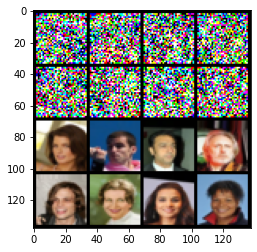

Epoch 1 : 


loss: 0.1958: 100%|██████████| 141/141 [00:31<00:00,  4.47it/s]


Epoch 2 : 


loss: 0.1445: 100%|██████████| 141/141 [00:30<00:00,  4.55it/s]


Epoch 3 : 


loss: 0.1248: 100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 4 : 


loss: 0.1109: 100%|██████████| 141/141 [00:30<00:00,  4.57it/s]


Epoch 5 : 


loss: 0.0977: 100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


Epoch 6 : 


loss: 0.0965: 100%|██████████| 141/141 [00:30<00:00,  4.60it/s]


Epoch 7 : 


loss: 0.0860: 100%|██████████| 141/141 [00:31<00:00,  4.46it/s]


Epoch 8 : 


loss: 0.0856: 100%|██████████| 141/141 [00:30<00:00,  4.56it/s]


Epoch 9 : 


loss: 0.0799: 100%|██████████| 141/141 [00:31<00:00,  4.42it/s]


Epoch 10 : 


loss: 0.0766: 100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


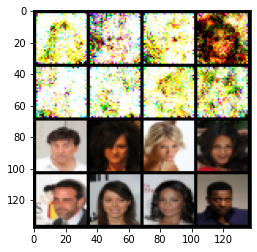

Epoch 11 : 


loss: 0.0708: 100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


Epoch 12 : 


loss: 0.0671: 100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 13 : 


loss: 0.0699: 100%|██████████| 141/141 [00:32<00:00,  4.37it/s]


Epoch 14 : 


loss: 0.0681: 100%|██████████| 141/141 [00:31<00:00,  4.51it/s]


Epoch 15 : 


loss: 0.0618: 100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


Epoch 16 : 


loss: 0.0646: 100%|██████████| 141/141 [00:31<00:00,  4.55it/s]


Epoch 17 : 


loss: 0.0616: 100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


Epoch 18 : 


loss: 0.0610: 100%|██████████| 141/141 [00:31<00:00,  4.54it/s]


Epoch 19 : 


loss: 0.0611: 100%|██████████| 141/141 [00:31<00:00,  4.43it/s]


Epoch 20 : 


loss: 0.0577: 100%|██████████| 141/141 [00:31<00:00,  4.53it/s]


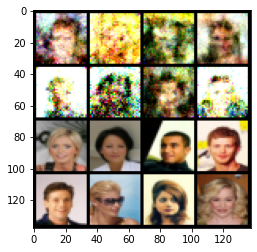

Epoch 21 : 


loss: 0.0603: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 22 : 


loss: 0.0576: 100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


Epoch 23 : 


loss: 0.0549: 100%|██████████| 141/141 [00:32<00:00,  4.35it/s]


Epoch 24 : 


loss: 0.0534: 100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


Epoch 25 : 


loss: 0.0542: 100%|██████████| 141/141 [00:32<00:00,  4.38it/s]


Epoch 26 : 


loss: 0.0543: 100%|██████████| 141/141 [00:31<00:00,  4.51it/s]


Epoch 27 : 


loss: 0.0526: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 28 : 


loss: 0.0538: 100%|██████████| 141/141 [00:31<00:00,  4.49it/s]


Epoch 29 : 


loss: 0.0518: 100%|██████████| 141/141 [00:32<00:00,  4.36it/s]


Epoch 30 : 


loss: 0.0454: 100%|██████████| 141/141 [00:31<00:00,  4.42it/s]


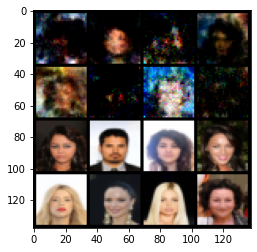

Epoch 31 : 


loss: 0.0472: 100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


Epoch 32 : 


loss: 0.0498: 100%|██████████| 141/141 [00:32<00:00,  4.34it/s]


Epoch 33 : 


loss: 0.0493: 100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 34 : 


loss: 0.0495: 100%|██████████| 141/141 [00:32<00:00,  4.36it/s]


Epoch 35 : 


loss: 0.0461: 100%|██████████| 141/141 [00:31<00:00,  4.47it/s]


Epoch 36 : 


loss: 0.0456: 100%|██████████| 141/141 [00:32<00:00,  4.38it/s]


Epoch 37 : 


loss: 0.0478: 100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


Epoch 38 : 


loss: 0.0454: 100%|██████████| 141/141 [00:32<00:00,  4.36it/s]


Epoch 39 : 


loss: 0.0436: 100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


Epoch 40 : 


loss: 0.0463: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


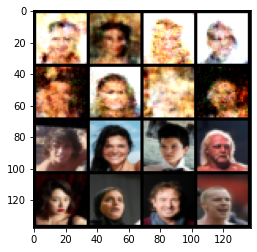

Epoch 41 : 


loss: 0.0439: 100%|██████████| 141/141 [00:31<00:00,  4.43it/s]


Epoch 42 : 


loss: 0.0444: 100%|██████████| 141/141 [00:32<00:00,  4.28it/s]


Epoch 43 : 


loss: 0.0451: 100%|██████████| 141/141 [00:31<00:00,  4.47it/s]


Epoch 44 : 


loss: 0.0427: 100%|██████████| 141/141 [00:32<00:00,  4.34it/s]


Epoch 45 : 


loss: 0.0429: 100%|██████████| 141/141 [00:31<00:00,  4.43it/s]


Epoch 46 : 


loss: 0.0442: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 47 : 


loss: 0.0478: 100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


Epoch 48 : 


loss: 0.0416: 100%|██████████| 141/141 [00:32<00:00,  4.37it/s]


Epoch 49 : 


loss: 0.0426: 100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 50 : 


loss: 0.0438: 100%|██████████| 141/141 [00:32<00:00,  4.34it/s]


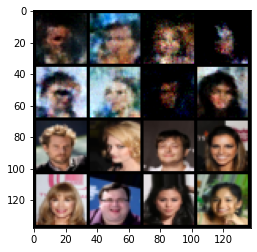

Epoch 51 : 


loss: 0.0458: 100%|██████████| 141/141 [00:32<00:00,  4.32it/s]


Epoch 52 : 


loss: 0.0419: 100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


Epoch 53 : 


loss: 0.0412: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 54 : 


loss: 0.0415: 100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 55 : 


loss: 0.0408: 100%|██████████| 141/141 [00:32<00:00,  4.32it/s]


Epoch 56 : 


loss: 0.0431: 100%|██████████| 141/141 [00:31<00:00,  4.43it/s]


Epoch 57 : 


loss: 0.0428: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 58 : 


loss: 0.0442: 100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 59 : 


loss: 0.0367: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 60 : 


loss: 0.0404: 100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


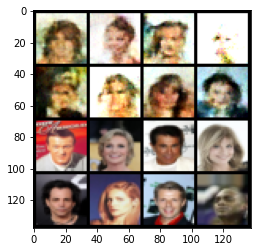

Epoch 61 : 


loss: 0.0415: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 62 : 


loss: 0.0374: 100%|██████████| 141/141 [00:32<00:00,  4.41it/s]


Epoch 63 : 


loss: 0.0404: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 64 : 


loss: 0.0429: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 65 : 


loss: 0.0437: 100%|██████████| 141/141 [00:32<00:00,  4.39it/s]


Epoch 66 : 


loss: 0.0391: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 67 : 


loss: 0.0403: 100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


Epoch 68 : 


loss: 0.0376: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 69 : 


loss: 0.0410: 100%|██████████| 141/141 [00:32<00:00,  4.39it/s]


Epoch 70 : 


loss: 0.0366: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


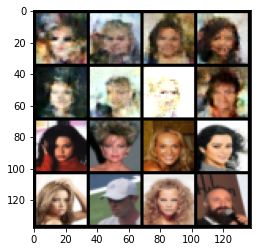

Epoch 71 : 


loss: 0.0387: 100%|██████████| 141/141 [00:32<00:00,  4.38it/s]


Epoch 72 : 


loss: 0.0399: 100%|██████████| 141/141 [00:32<00:00,  4.28it/s]


Epoch 73 : 


loss: 0.0364: 100%|██████████| 141/141 [00:32<00:00,  4.39it/s]


Epoch 74 : 


loss: 0.0394: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 75 : 


loss: 0.0395: 100%|██████████| 141/141 [00:32<00:00,  4.39it/s]


Epoch 76 : 


loss: 0.0408: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 77 : 


loss: 0.0383: 100%|██████████| 141/141 [00:31<00:00,  4.42it/s]


Epoch 78 : 


loss: 0.0382: 100%|██████████| 141/141 [00:32<00:00,  4.28it/s]


Epoch 79 : 


loss: 0.0392: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 80 : 


loss: 0.0380: 100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


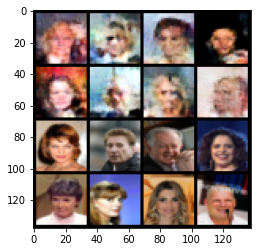

Epoch 81 : 


loss: 0.0395: 100%|██████████| 141/141 [00:33<00:00,  4.24it/s]


Epoch 82 : 


loss: 0.0371: 100%|██████████| 141/141 [00:32<00:00,  4.38it/s]


Epoch 83 : 


loss: 0.0381: 100%|██████████| 141/141 [00:33<00:00,  4.25it/s]


Epoch 84 : 


loss: 0.0370: 100%|██████████| 141/141 [00:32<00:00,  4.38it/s]


Epoch 85 : 


loss: 0.0381: 100%|██████████| 141/141 [00:33<00:00,  4.25it/s]


Epoch 86 : 


loss: 0.0399: 100%|██████████| 141/141 [00:32<00:00,  4.35it/s]


Epoch 87 : 


loss: 0.0344: 100%|██████████| 141/141 [00:33<00:00,  4.27it/s]


Epoch 88 : 


loss: 0.0391: 100%|██████████| 141/141 [00:32<00:00,  4.37it/s]


Epoch 89 : 


loss: 0.0375: 100%|██████████| 141/141 [00:33<00:00,  4.27it/s]


Epoch 90 : 


loss: 0.0407: 100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


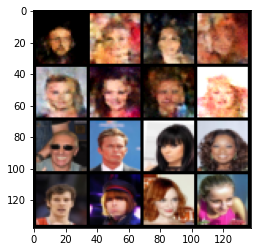

Epoch 91 : 


loss: 0.0394: 100%|██████████| 141/141 [00:32<00:00,  4.38it/s]


Epoch 92 : 


loss: 0.0363: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 93 : 


loss: 0.0364: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 94 : 


loss: 0.0376: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 95 : 


loss: 0.0374: 100%|██████████| 141/141 [00:32<00:00,  4.35it/s]


Epoch 96 : 


loss: 0.0344: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 97 : 


loss: 0.0369: 100%|██████████| 141/141 [00:32<00:00,  4.36it/s]


Epoch 98 : 


loss: 0.0349: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 99 : 


loss: 0.0360: 100%|██████████| 141/141 [00:32<00:00,  4.35it/s]


Epoch 100 : 


loss: 0.0408: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


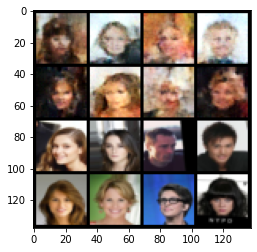

Epoch 101 : 


loss: 0.0356: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 102 : 


loss: 0.0351: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 103 : 


loss: 0.0365: 100%|██████████| 141/141 [00:33<00:00,  4.21it/s]


Epoch 104 : 


loss: 0.0331: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 105 : 


loss: 0.0378: 100%|██████████| 141/141 [00:33<00:00,  4.21it/s]


Epoch 106 : 


loss: 0.0390: 100%|██████████| 141/141 [00:32<00:00,  4.35it/s]


Epoch 107 : 


loss: 0.0349: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 108 : 


loss: 0.0347: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 109 : 


loss: 0.0373: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 110 : 


loss: 0.0358: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


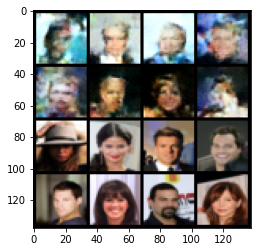

Epoch 111 : 


loss: 0.0355: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 112 : 


loss: 0.0350: 100%|██████████| 141/141 [00:33<00:00,  4.18it/s]


Epoch 113 : 


loss: 0.0351: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 114 : 


loss: 0.0374: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 115 : 


loss: 0.0347: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 116 : 


loss: 0.0371: 100%|██████████| 141/141 [00:33<00:00,  4.21it/s]


Epoch 117 : 


loss: 0.0358: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 118 : 


loss: 0.0352: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 119 : 


loss: 0.0352: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 120 : 


loss: 0.0378: 100%|██████████| 141/141 [00:33<00:00,  4.18it/s]


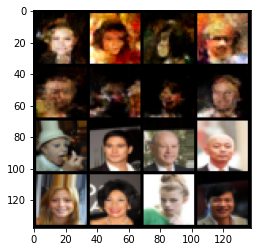

Epoch 121 : 


loss: 0.0349: 100%|██████████| 141/141 [00:33<00:00,  4.18it/s]


Epoch 122 : 


loss: 0.0357: 100%|██████████| 141/141 [00:32<00:00,  4.32it/s]


Epoch 123 : 


loss: 0.0348: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 124 : 


loss: 0.0367: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 125 : 


loss: 0.0359: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 126 : 


loss: 0.0359: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 127 : 


loss: 0.0366: 100%|██████████| 141/141 [00:33<00:00,  4.17it/s]


Epoch 128 : 


loss: 0.0317: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 129 : 


loss: 0.0336: 100%|██████████| 141/141 [00:33<00:00,  4.21it/s]


Epoch 130 : 


loss: 0.0351: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


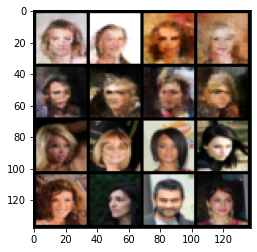

Epoch 131 : 


loss: 0.0337: 100%|██████████| 141/141 [00:33<00:00,  4.27it/s]


Epoch 132 : 


loss: 0.0362: 100%|██████████| 141/141 [00:33<00:00,  4.17it/s]


Epoch 133 : 


loss: 0.0342: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 134 : 


loss: 0.0349: 100%|██████████| 141/141 [00:33<00:00,  4.16it/s]


Epoch 135 : 


loss: 0.0340: 100%|██████████| 141/141 [00:33<00:00,  4.27it/s]


Epoch 136 : 


loss: 0.0363: 100%|██████████| 141/141 [00:33<00:00,  4.19it/s]


Epoch 137 : 


loss: 0.0356: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 138 : 


loss: 0.0337: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 139 : 


loss: 0.0344: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 140 : 


loss: 0.0349: 100%|██████████| 141/141 [00:32<00:00,  4.34it/s]


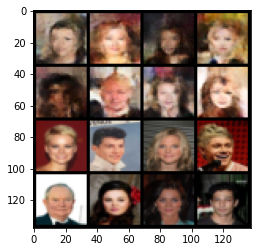

Epoch 141 : 


loss: 0.0347: 100%|██████████| 141/141 [00:33<00:00,  4.24it/s]


Epoch 142 : 


loss: 0.0370: 100%|██████████| 141/141 [00:32<00:00,  4.34it/s]


Epoch 143 : 


loss: 0.0348: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 144 : 


loss: 0.0321: 100%|██████████| 141/141 [00:32<00:00,  4.32it/s]


Epoch 145 : 


loss: 0.0347: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 146 : 


loss: 0.0356: 100%|██████████| 141/141 [00:33<00:00,  4.24it/s]


Epoch 147 : 


loss: 0.0364: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 148 : 


loss: 0.0341: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 149 : 


loss: 0.0353: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 150 : 


loss: 0.0358: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


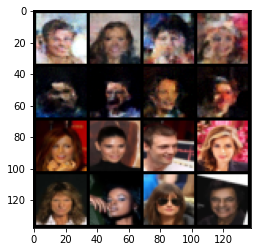

Epoch 151 : 


loss: 0.0350: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


Epoch 152 : 


loss: 0.0342: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 153 : 


loss: 0.0321: 100%|██████████| 141/141 [00:32<00:00,  4.32it/s]


Epoch 154 : 


loss: 0.0382: 100%|██████████| 141/141 [00:33<00:00,  4.25it/s]


Epoch 155 : 


loss: 0.0352: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 156 : 


loss: 0.0341: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 157 : 


loss: 0.0361: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 158 : 


loss: 0.0326: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 159 : 


loss: 0.0368: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 160 : 


loss: 0.0332: 100%|██████████| 141/141 [00:32<00:00,  4.33it/s]


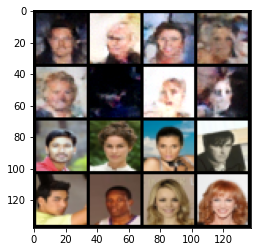

Epoch 161 : 


loss: 0.0358: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 162 : 


loss: 0.0327: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 163 : 


loss: 0.0344: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 164 : 


loss: 0.0319: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 165 : 


loss: 0.0327: 100%|██████████| 141/141 [00:32<00:00,  4.30it/s]


Epoch 166 : 


loss: 0.0355: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 167 : 


loss: 0.0318: 100%|██████████| 141/141 [00:32<00:00,  4.28it/s]


Epoch 168 : 


loss: 0.0322: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 169 : 


loss: 0.0353: 100%|██████████| 141/141 [00:32<00:00,  4.28it/s]


Epoch 170 : 


loss: 0.0348: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


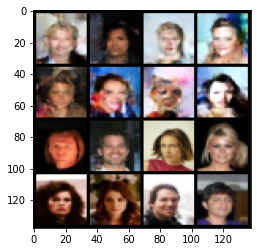

Epoch 171 : 


loss: 0.0338: 100%|██████████| 141/141 [00:32<00:00,  4.31it/s]


Epoch 172 : 


loss: 0.0342: 100%|██████████| 141/141 [00:33<00:00,  4.19it/s]


Epoch 173 : 


loss: 0.0354: 100%|██████████| 141/141 [00:32<00:00,  4.29it/s]


Epoch 174 : 


loss: 0.0337: 100%|██████████| 141/141 [00:33<00:00,  4.21it/s]


Epoch 175 : 


loss: 0.0301: 100%|██████████| 141/141 [00:33<00:00,  4.15it/s]


Epoch 176 : 


loss: 0.0349: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 177 : 


loss: 0.0337: 100%|██████████| 141/141 [00:33<00:00,  4.15it/s]


Epoch 178 : 


loss: 0.0329: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 179 : 


loss: 0.0347: 100%|██████████| 141/141 [00:34<00:00,  4.14it/s]


Epoch 180 : 


loss: 0.0339: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


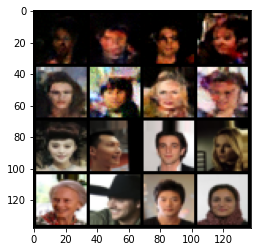

Epoch 181 : 


loss: 0.0340: 100%|██████████| 141/141 [00:34<00:00,  4.14it/s]


Epoch 182 : 


loss: 0.0348: 100%|██████████| 141/141 [00:33<00:00,  4.21it/s]


Epoch 183 : 


loss: 0.0341: 100%|██████████| 141/141 [00:34<00:00,  4.14it/s]


Epoch 184 : 


loss: 0.0328: 100%|██████████| 141/141 [00:34<00:00,  4.13it/s]


Epoch 185 : 


loss: 0.0354: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 186 : 


loss: 0.0334: 100%|██████████| 141/141 [00:34<00:00,  4.12it/s]


Epoch 187 : 


loss: 0.0336: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 188 : 


loss: 0.0332: 100%|██████████| 141/141 [00:33<00:00,  4.15it/s]


Epoch 189 : 


loss: 0.0331: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 190 : 


loss: 0.0328: 100%|██████████| 141/141 [00:33<00:00,  4.16it/s]


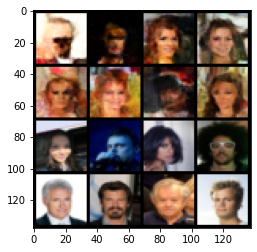

Epoch 191 : 


loss: 0.0301: 100%|██████████| 141/141 [00:33<00:00,  4.26it/s]


Epoch 192 : 


loss: 0.0332: 100%|██████████| 141/141 [00:33<00:00,  4.19it/s]


Epoch 193 : 


loss: 0.0339: 100%|██████████| 141/141 [00:33<00:00,  4.15it/s]


Epoch 194 : 


loss: 0.0334: 100%|██████████| 141/141 [00:33<00:00,  4.27it/s]


Epoch 195 : 


loss: 0.0340: 100%|██████████| 141/141 [00:33<00:00,  4.19it/s]


Epoch 196 : 


loss: 0.0315: 100%|██████████| 141/141 [00:32<00:00,  4.28it/s]


Epoch 197 : 


loss: 0.0327: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 198 : 


loss: 0.0318: 100%|██████████| 141/141 [00:33<00:00,  4.24it/s]


Epoch 199 : 


loss: 0.0324: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 200 : 


loss: 0.0307: 100%|██████████| 141/141 [00:33<00:00,  4.27it/s]


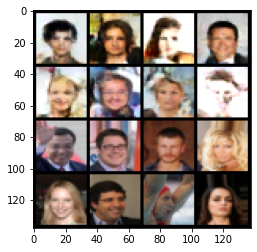

Epoch 201 : 


loss: 0.0332: 100%|██████████| 141/141 [00:33<00:00,  4.18it/s]


Epoch 202 : 


loss: 0.0334: 100%|██████████| 141/141 [00:33<00:00,  4.22it/s]


Epoch 203 : 


loss: 0.0330: 100%|██████████| 141/141 [00:33<00:00,  4.18it/s]


Epoch 204 : 


loss: 0.0307: 100%|██████████| 141/141 [00:33<00:00,  4.17it/s]


Epoch 205 : 


loss: 0.0324: 100%|██████████| 141/141 [00:33<00:00,  4.23it/s]


Epoch 206 : 


loss: 0.0316: 100%|██████████| 141/141 [00:33<00:00,  4.19it/s]


Epoch 207 : 


loss: 0.0307: 100%|██████████| 141/141 [00:33<00:00,  4.24it/s]


Epoch 208 : 


loss: 0.0328: 100%|██████████| 141/141 [00:33<00:00,  4.19it/s]


Epoch 209 : 


loss: 0.0332: 100%|██████████| 141/141 [00:33<00:00,  4.25it/s]


Epoch 210 : 


loss: 0.0299: 100%|██████████| 141/141 [00:33<00:00,  4.16it/s]


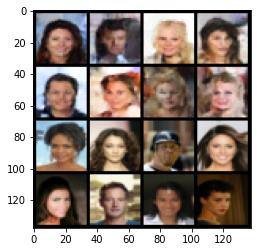

Epoch 211 : 


loss: 0.0324: 100%|██████████| 141/141 [00:33<00:00,  4.24it/s]


Epoch 212 : 


loss: 0.0331: 100%|██████████| 141/141 [00:34<00:00,  4.14it/s]


Epoch 213 : 


loss: 0.0320: 100%|██████████| 141/141 [00:33<00:00,  4.20it/s]


Epoch 214 : 


loss: 0.0316:  78%|███████▊  | 110/141 [00:25<00:07,  4.19it/s]

In [ ]:
train(ddpm, n_epoch=1000, dataset=subset, x_size=x_size, y_size=y_size, modulo_print=10)

### Testing


In [ ]:
!pip install transformers

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
def norm(tensor, value_range):
  tensor = tensor.clone()  # avoid modifying tensor in-place
  if value_range is not None and not isinstance(value_range, tuple):
      raise TypeError("value_range has to be a tuple (min, max) if specified. min and max are numbers")

  def norm_ip(img, low, high):
      img.clamp_(min=low, max=high)
      img.sub_(low).div_(max(high - low, 1e-5))

  def norm_range(t, value_range):
      if value_range is not None:
          norm_ip(t, value_range[0], value_range[1])
      else:
          norm_ip(t, float(t.min()), float(t.max()))
  norm_range(tensor, value_range)
  return tensor

In [ ]:
def guide(guided_img, score):
  with torch.no_grad():
    x = ddpm.sample(8, (3, 32, 32), "cuda:0", guided_img, 2000)
    xx = torch.cat([x, x], dim=0)
    grid = make_grid(xx, normalize=True, value_range=(-1, 1), nrow=4)
    plt.imshow(
      transforms.functional.vflip(
        transforms.functional.rotate(grid.cpu(), 90).T)
    )
    plt.show()
    i = 0
    ii = []
    ii_logits = []
    best_idx = 0
    best_score = 0
    for t in x.cpu():
      ii.append(t)
      img = transforms.ToPILImage(mode='RGB')(norm(t, value_range=(-1, 1)))
      # print(img)
      # plt.imshow(img)
      # plt.show()
      inputs = processor(text=["cat","tree"], images=img, return_tensors="pt", padding=True)
      outputs = model(**inputs)
      logits_per_image = outputs.logits_per_image # this is the image-text similarity score
      # probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
      ii_logits.append(logits_per_image.numpy()[0][0])
      # print(logits_per_image)
      # print(ii_logits)
      best_score = max(ii_logits)
      best_idx = ii_logits.index(best_score)
      # print(best_idx)

    print(best_idx)
    # print(ii[best_idx].shape)
    # print(best_score)
    b = ii[best_idx].cuda()[None, :, :, :]
    best_stacked = torch.cat([b,b,b,b,b,b,b,b],dim=0)
    if best_score > score:
      print("Improved!")
      print(best_score)
      guide(best_stacked,best_score)
    else:
      print(score)
      guide(guided_img,score)

In [ ]:
guide(None,0.0)


### Playground

In [ ]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
# gpu_usage()   

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  